In [1]:
import sys

import numpy as np
from matplotlib import pyplot as plt
import cv2
import time
import itertools
from scipy.ndimage import label
import warnings
from sklearn.metrics import precision_recall_curve, auc

from helpers import *
from gaussian_diffusion import GaussianDiffusionModel, get_beta_schedule
from unet import UNetModel
import data_loader
from anomaly_detection import *
import skimage.exposure

from torchvision import transforms
import random
import lpips
from torch.cuda.amp import autocast
import cv2

/home/camp/anaconda3/envs/diffusion/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
pretrained_path = '../output/Ultrasound/model/args_us_28/best_model.pt'

betas = get_beta_schedule("cosine", 1000)

diffusion = GaussianDiffusionModel(
            128, betas, img_channels=1, loss_type="vlb",
            loss_weight="none", noise_fn="coarse", noise_params=None, diffusion_mode="inference"
            )

model = UNetModel(128, in_channels=1, model_channels=128,
                num_res_blocks=2, attention_resolutions="32,16,8",
                dropout=0.0, channel_mult="", num_heads=2,
                num_head_channels=64,).to('cuda')

checkpoint = torch.load(pretrained_path)
model.load_state_dict(checkpoint["model_state_dict"])
model.to('cuda')
model.eval()

UNetModel(
  (time_embed): Sequential(
    (0): Linear(in_features=128, out_features=512, bias=True)
    (1): SiLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
  )
  (input_blocks): ModuleList(
    (0): TimestepEmbedSequential(
      (0): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (1-2): 2 x TimestepEmbedSequential(
      (0): ResBlock(
        (in_layers): Sequential(
          (0): GroupNorm32(32, 128, eps=1e-05, affine=True)
          (1): SiLU()
          (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (h_upd): Identity()
        (x_upd): Identity()
        (emb_layers): Sequential(
          (0): SiLU()
          (1): Linear(in_features=512, out_features=128, bias=True)
        )
        (out_layers): Sequential(
          (0): GroupNorm32(32, 128, eps=1e-05, affine=True)
          (1): SiLU()
          (2): Dropout(p=0.0, inplace=False)
          (3): Conv2d(128, 128, kernel_size=(3, 3)

In [2]:
def normalize_image(image, low, high):
    """
    Normalize the input image to the range [low, high].

    :param image: Input image as a NumPy array.
    :param low: The lower bound of the target range.
    :param high: The upper bound of the target range.

    :return: The normalized image as a NumPy array.
    """
    # Find the minimum and maximum pixel values in the image
    min_val = np.min(image)
    max_val = np.max(image)

    # Normalize the image to the range [low, high]
    normalized_image = (image - min_val) / (max_val - min_val) * (high - low) + low

    # Convert the image to the appropriate data type (uint8 for an image)
    normalized_image = normalized_image

    return normalized_image

def create_gaussian_blur_difference_map(x_0, x_pred, kernel_size=3, threshold=5.0):
    """
    Create a difference map between the input image and the predicted input image with Gaussian blur.

    :param x_0: input image
    :param x_pred: predicted input image
    :param kernel_size: kernel size for Gaussian blur
    :param threshold: threshold for anomaly
    :return: difference map
    """

    x_0_array = x_0.cpu().squeeze().numpy()
    x_0_blurred = cv2.GaussianBlur(x_0_array, (kernel_size, kernel_size), 0)
    x_pred_array = x_pred.cpu().detach().numpy().squeeze()
    x_pred_blurred = cv2.GaussianBlur(x_pred_array, (kernel_size, kernel_size), 0)

    diff = abs(x_0_blurred - x_pred_blurred)
    diff[diff < threshold] = 0

    diff_final = remove_small_spots(diff)
    return diff_final


def remove_small_spots(map, threshold=30):
    """
    Remove too small spots from the difference map.

    :param map: difference map
    :param threshold: threshold for the size of the spots
    :return: difference map with removed small spots
    """

    binary_map = map > 0
    labeled_map, num_features = label(binary_map)
    component_sizes = np.bincount(labeled_map.ravel())
    large_components_masked = component_sizes[labeled_map] >= threshold
    return large_components_masked * map

(128, 128)


True

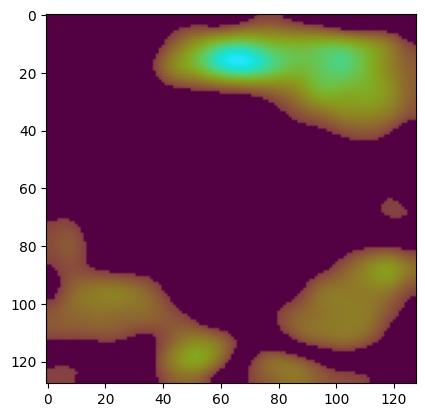

In [8]:
img = cv2.imread('/home/camp/Projects/Yuan/thesis_diffusion-main/output/Ultrasound/paper_images/us_coarse_1_2_0.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = cv2.resize(img, (128, 128))
img = normalize_image(img, -1, 1)
x_0 = torch.from_numpy(img).float().view(1,1,128,128).to('cuda')

with torch.no_grad():
    t = torch.tensor([800], device=x_0.device).repeat(x_0.shape[0])
    noise = diffusion.noise_fn(x_0, None)
    x_t = diffusion.q_sample(x_0, t, noise)
    x_rec = diffusion.p_sample(model, x_t, t)

rec = x_rec.cpu().detach().numpy().squeeze()

rec = normalize_image(rec, 0, 255)
print(rec.shape)
plt.imshow(rec, cmap='gray')
cv2.imwrite('/home/camp/Projects/Yuan/thesis_diffusion-main/output/Ultrasound/paper_images/us_coarse.png', rec)





anomaly_map = create_gaussian_blur_difference_map(x_0,x_rec,kernel_size=21, threshold=0.1)

anomaly_map = normalize_image(anomaly_map,0,1)
anomaly_map = plt.cm.viridis(anomaly_map)
anomaly_map = anomaly_map[:, :, :3]

anomaly_map = (anomaly_map * 255).astype(np.uint8)
anomaly_map = cv2.cvtColor(anomaly_map, cv2.COLOR_RGB2BGR)

plt.imshow(anomaly_map)
cv2.imwrite('/home/camp/Projects/Yuan/thesis_diffusion-main/output/Ultrasound/paper_images/us_coarse_anomaly_map.png', anomaly_map)

In [2]:
pretrained_path = '../output/Ultrasound/model/args_us_25/best_model.pt'

betas = get_beta_schedule("cosine", 1000)

diffusion = GaussianDiffusionModel(
            128, betas, img_channels=1, loss_type="vlb",
            loss_weight="none", noise_fn="gaussian", noise_params=None, diffusion_mode="inference"
            )

model = UNetModel(128, in_channels=1, model_channels=128,
                num_res_blocks=2, attention_resolutions="32,16,8",
                dropout=0.0, channel_mult="", num_heads=2,
                num_head_channels=64,).to('cuda')

checkpoint = torch.load(pretrained_path)
model.load_state_dict(checkpoint["model_state_dict"])
model.to('cuda')
model.eval()

UNetModel(
  (time_embed): Sequential(
    (0): Linear(in_features=128, out_features=512, bias=True)
    (1): SiLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
  )
  (input_blocks): ModuleList(
    (0): TimestepEmbedSequential(
      (0): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (1-2): 2 x TimestepEmbedSequential(
      (0): ResBlock(
        (in_layers): Sequential(
          (0): GroupNorm32(32, 128, eps=1e-05, affine=True)
          (1): SiLU()
          (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (h_upd): Identity()
        (x_upd): Identity()
        (emb_layers): Sequential(
          (0): SiLU()
          (1): Linear(in_features=512, out_features=128, bias=True)
        )
        (out_layers): Sequential(
          (0): GroupNorm32(32, 128, eps=1e-05, affine=True)
          (1): SiLU()
          (2): Dropout(p=0.0, inplace=False)
          (3): Conv2d(128, 128, kernel_size=(3, 3)

In [3]:
def normalize_image(image, low, high):
    """
    Normalize the input image to the range [low, high].

    :param image: Input image as a NumPy array.
    :param low: The lower bound of the target range.
    :param high: The upper bound of the target range.

    :return: The normalized image as a NumPy array.
    """
    # Find the minimum and maximum pixel values in the image
    min_val = np.min(image)
    max_val = np.max(image)

    # Normalize the image to the range [low, high]
    normalized_image = (image - min_val) / (max_val - min_val) * (high - low) + low

    # Convert the image to the appropriate data type (uint8 for an image)
    normalized_image = normalized_image

    return normalized_image

def create_gaussian_blur_difference_map(x_0, x_pred, kernel_size=3, threshold=5.0):
    """
    Create a difference map between the input image and the predicted input image with Gaussian blur.

    :param x_0: input image
    :param x_pred: predicted input image
    :param kernel_size: kernel size for Gaussian blur
    :param threshold: threshold for anomaly
    :return: difference map
    """

    x_0_array = x_0.cpu().squeeze().numpy()
    x_0_blurred = cv2.GaussianBlur(x_0_array, (kernel_size, kernel_size), 0)
    x_pred_array = x_pred.cpu().detach().numpy().squeeze()
    x_pred_blurred = cv2.GaussianBlur(x_pred_array, (kernel_size, kernel_size), 0)

    diff = abs(x_0_blurred - x_pred_blurred)
    diff[diff < threshold] = 0

    diff_final = remove_small_spots(diff)
    return diff_final


def remove_small_spots(map, threshold=30):
    """
    Remove too small spots from the difference map.

    :param map: difference map
    :param threshold: threshold for the size of the spots
    :return: difference map with removed small spots
    """

    binary_map = map > 0
    labeled_map, num_features = label(binary_map)
    component_sizes = np.bincount(labeled_map.ravel())
    large_components_masked = component_sizes[labeled_map] >= threshold
    return large_components_masked * map

In [4]:
def lpips_loss(l_pips_sq, anomaly_img, ph_img, retPerLayer=False):
    """
    :param anomaly_img: anomaly image
    :param ph_img: pseudo-healthy image
    :param retPerLayer: whether to return the loss per layer
    :return: LPIPS loss
    """
    if len(ph_img.shape) < 2:
        print('Image should have 2 dimensions at lease (LPIPS)')
        return
    if len(ph_img.shape) == 2:
        ph_img = torch.unsqueeze(torch.unsqueeze(ph_img, 0), 0)
        anomaly_img = torch.unsqueeze(torch.unsqueeze(anomaly_img, 0), 0)
    if len(ph_img.shape) == 3:
        ph_img = torch.unsqueeze(ph_img, 0)
        anomaly_img = torch.unsqueeze(anomaly_img, 0)

    saliency_maps = []
    for batch_id in range(anomaly_img.size(0)):
        lpips = l_pips_sq(2*anomaly_img[batch_id:batch_id + 1, :, :, :]-1, 2*ph_img[batch_id:batch_id + 1, :, :, :]-1,
                               normalize=True, retPerLayer=retPerLayer)
        if retPerLayer:
            lpips = lpips[1][0]
        saliency_maps.append(lpips[0,:,:,:].cpu().detach().numpy())
    return np.asarray(saliency_maps)

In [5]:
def dilate_masks(masks):
    """
    :param masks: masks to dilate
    :return: dilated masks
    """
    kernel = np.ones((3, 3), np.uint8)

    dilated_masks = torch.zeros_like(masks)
    for i in range(masks.shape[0]):
        mask = masks[i][0].detach().cpu().numpy()
        if np.sum(mask) < 1:
            dilated_masks[i] = masks[i]
            continue
        dilated_mask = cv2.dilate(mask, kernel, iterations=1)
        dilated_mask = torch.from_numpy(dilated_mask).to(masks.device).unsqueeze(dim=0)
        dilated_masks[i] = dilated_mask

    return dilated_masks

Setting up [LPIPS] perceptual loss: trunk [squeeze], v[0.1], spatial [on]
Loading model from: /home/camp/anaconda3/envs/diffusion/lib/python3.11/site-packages/lpips/weights/v0.1/squeeze.pth


/home/camp/anaconda3/envs/diffusion/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/camp/anaconda3/envs/diffusion/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_1_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_1_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


(128, 128)


True

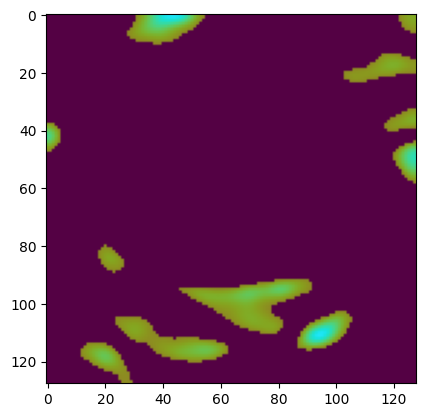

In [6]:
img = cv2.imread('/home/camp/Projects/Yuan/thesis_diffusion-main/output/Ultrasound/paper_images/us_coarse_1_2_0.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = cv2.resize(img, (128, 128))
img = normalize_image(img, -1, 1)
x_0 = torch.from_numpy(img).float().view(1,1,128,128).to('cuda')

l_pips_sq = lpips.LPIPS(pretrained=True, net='squeeze', use_dropout=True, eval_mode=True,spatial=True, lpips=True).to('cuda')

device = 'cuda'

with torch.no_grad():
    t = torch.tensor([800], device=x_0.device).repeat(x_0.shape[0])
    noise = diffusion.noise_fn(x_0, None)
    x_t = diffusion.q_sample(x_0, t, noise)
    x_rec = diffusion.p_sample(model, x_t, t)

    # x_rec = torch.clamp(x_rec, 0, 1)
    # x_res = self.ano_map.compute_residual(inputs, x_rec, hist_eq=False)
    x_res = np.abs(x_rec.cpu().detach().numpy() - x_0.cpu().detach().numpy())
    lpips_mask = lpips_loss(l_pips_sq, x_0, x_rec, retPerLayer=False)
    #
    # anomalous: high value, healthy: low value
    x_res = np.asarray([(x_res[i] / np.percentile(x_res[i], 95)) for i in range(x_res.shape[0])]).clip(0, 1)
    combined_mask_np = lpips_mask * x_res
    combined_mask = torch.Tensor(combined_mask_np).to(device)
    masking_threshold = torch.tensor(np.asarray([(
        np.percentile(combined_mask[i].cpu().detach().numpy(), 95)) for i in
        range(combined_mask.shape[0])]).clip(0,
                                             1))
    combined_mask_binary = torch.cat([torch.where(combined_mask[i] > masking_threshold[i], torch.ones_like(
        torch.unsqueeze(combined_mask[i], 0)), torch.zeros_like(combined_mask[i]))
                                      for i in range(combined_mask.shape[0])], dim=0)

    combined_mask_binary_dilated = dilate_masks(combined_mask_binary)
    mask_in_use = combined_mask_binary_dilated

    x_masked = (1 - mask_in_use) * x_0
    x_rec_masked = mask_in_use * x_rec
    #
    #
    # 2. Start in-painting with reconstructed image and not pure noise

    timesteps = torch.tensor([400], device=x_rec.device).repeat(x_rec.shape[0])
    noise = diffusion.noise_fn(x_rec, None)
    inpaint_image = diffusion.q_sample(x_rec, timesteps, noise)


    # 3. Setup for loop
    # timesteps = self.inference_scheduler.get_timesteps(50)
    timesteps = torch.from_numpy(np.arange(0, 400 + 1)[::-1].copy())
    progress_bar = iter(timesteps)
    num_resample_steps = 4
    stitched_images = []

    # 4. Inpainting loop
    with torch.no_grad():
        with autocast(enabled=True):
            for t in progress_bar:
                for u in range(num_resample_steps):
                    # 4a) Get the known portion at t-1
                    if t > 0:
                        # noise = torch.randn_like(x_0, device=device)
                        # timesteps_prev = torch.full([x_0.shape[0]], t - 1, device=device).long()
                        # noised_masked_original_context = self.inference_scheduler.add_noise(
                        #     original_samples=x_masked, noise=noise, timesteps=timesteps_prev
                        # )
                        timesteps_prev = torch.tensor([t - 1], device=x_0.device).repeat(x_0.shape[0])
                        noise = diffusion.noise_fn(x_0, None)
                        noised_masked_original_context = diffusion.q_sample(x_masked, timesteps_prev, noise)
                    else:
                        noised_masked_original_context = x_masked
                    #
                    # 4b) Perform a denoising step to get the unknown portion at t-1
                    if t > 0:
                        # timesteps = torch.full([inputs.shape[0]], t, device=self.device).long()
                        # model_output = self.unet(x=inpaint_image, timesteps=timesteps)
                        # inpainted_from_x_rec, _ = self.inference_scheduler.step(model_output, t,
                        #                                                         inpaint_image)
                        timesteps = torch.tensor([t], device=inpaint_image.device).repeat(inpaint_image.shape[0])
                        out = diffusion.p_mean_variance(model, inpaint_image, timesteps)
                        inpainted_from_x_rec = out["pred_x_t_1"]

                    #
                    # 4c) Combine the known and unknown portions at t-1
                    inpaint_image = torch.where(
                        mask_in_use == 1, inpainted_from_x_rec, noised_masked_original_context
                    )

                    ## 4d) Perform resampling: sample x_t from x_t-1 -> get new image to be inpainted
                    # in the masked region
                    if t > 0 and u < (num_resample_steps - 1):
                        inpaint_image = (
                                torch.sqrt(1 - torch.tensor(diffusion.betas[t - 1]).to(device)) * inpaint_image
                                + torch.sqrt(torch.tensor(diffusion.betas[t - 1]).to(device))
                                * torch.randn_like(x_0, device=device)
                        )



rec = inpaint_image.cpu().detach().numpy().squeeze()

rec = normalize_image(rec, 0, 255)
print(rec.shape)
plt.imshow(rec, cmap='gray')
cv2.imwrite('/home/camp/Projects/Yuan/thesis_diffusion-main/output/Ultrasound/paper_images/us_autoddpm.png', rec)


anomaly_map = create_gaussian_blur_difference_map(x_0,x_rec,kernel_size=15, threshold=0.3)

anomaly_map = normalize_image(anomaly_map,0,1)
anomaly_map = plt.cm.viridis(anomaly_map)
anomaly_map = anomaly_map[:, :, :3]

anomaly_map = (anomaly_map * 255).astype(np.uint8)
anomaly_map = cv2.cvtColor(anomaly_map, cv2.COLOR_RGB2BGR)

plt.imshow(anomaly_map)
cv2.imwrite('/home/camp/Projects/Yuan/thesis_diffusion-main/output/Ultrasound/paper_images/us_autoddpm_anomaly_map.png', anomaly_map)

In [2]:
pretrained_path = '../output/Ultrasound/model/args_us_27/best_model.pt'

betas = get_beta_schedule("cosine", 1000)

diffusion = GaussianDiffusionModel(
            128, betas, img_channels=1, loss_type="vlb",
            loss_weight="none", noise_fn="gaussian", noise_params=None, diffusion_mode="inference"
            )

model = UNetModel(128, in_channels=1, model_channels=128,
                num_res_blocks=2, attention_resolutions="32,16,8",
                dropout=0.0, channel_mult="", num_heads=2,
                num_head_channels=64,).to('cuda')

checkpoint = torch.load(pretrained_path)
model.load_state_dict(checkpoint["model_state_dict"])
model.to('cuda')
model.eval()

UNetModel(
  (time_embed): Sequential(
    (0): Linear(in_features=128, out_features=512, bias=True)
    (1): SiLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
  )
  (input_blocks): ModuleList(
    (0): TimestepEmbedSequential(
      (0): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (1-2): 2 x TimestepEmbedSequential(
      (0): ResBlock(
        (in_layers): Sequential(
          (0): GroupNorm32(32, 128, eps=1e-05, affine=True)
          (1): SiLU()
          (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (h_upd): Identity()
        (x_upd): Identity()
        (emb_layers): Sequential(
          (0): SiLU()
          (1): Linear(in_features=512, out_features=128, bias=True)
        )
        (out_layers): Sequential(
          (0): GroupNorm32(32, 128, eps=1e-05, affine=True)
          (1): SiLU()
          (2): Dropout(p=0.0, inplace=False)
          (3): Conv2d(128, 128, kernel_size=(3, 3)

In [4]:
def normalize_image(image, low, high):
    """
    Normalize the input image to the range [low, high].

    :param image: Input image as a NumPy array.
    :param low: The lower bound of the target range.
    :param high: The upper bound of the target range.

    :return: The normalized image as a NumPy array.
    """
    # Find the minimum and maximum pixel values in the image
    min_val = np.min(image)
    max_val = np.max(image)

    # Normalize the image to the range [low, high]
    normalized_image = (image - min_val) / (max_val - min_val) * (high - low) + low

    # Convert the image to the appropriate data type (uint8 for an image)
    normalized_image = normalized_image

    return normalized_image

def create_gaussian_blur_difference_map(x_0, x_pred, kernel_size=3, threshold=5.0):
    """
    Create a difference map between the input image and the predicted input image with Gaussian blur.

    :param x_0: input image
    :param x_pred: predicted input image
    :param kernel_size: kernel size for Gaussian blur
    :param threshold: threshold for anomaly
    :return: difference map
    """

    x_0_array = x_0.cpu().squeeze().numpy()
    x_0_blurred = cv2.GaussianBlur(x_0_array, (kernel_size, kernel_size), 0)
    x_pred_array = x_pred.cpu().detach().numpy().squeeze()
    x_pred_blurred = cv2.GaussianBlur(x_pred_array, (kernel_size, kernel_size), 0)

    diff = abs(x_0_blurred - x_pred_blurred)
    diff[diff < threshold] = 0

    diff_final = remove_small_spots(diff)
    return diff_final


def remove_small_spots(map, threshold=30):
    """
    Remove too small spots from the difference map.

    :param map: difference map
    :param threshold: threshold for the size of the spots
    :return: difference map with removed small spots
    """

    binary_map = map > 0
    labeled_map, num_features = label(binary_map)
    component_sizes = np.bincount(labeled_map.ravel())
    large_components_masked = component_sizes[labeled_map] >= threshold
    return large_components_masked * map

(128, 128)


True

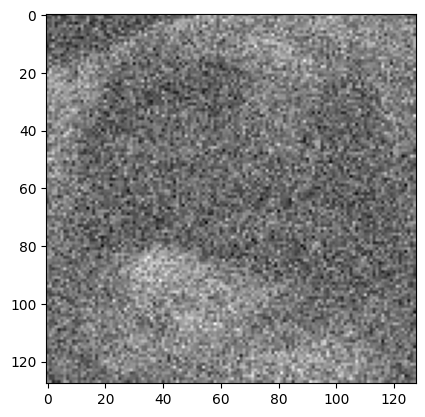

In [11]:
# img = cv2.imread('/home/camp/Projects/Yuan/thesis_diffusion-main/output/Ultrasound/paper_images/us_coarse_1_2_0.png')
img = cv2.imread('/home/camp/Projects/Yuan/thesis_diffusion-main/output/Ultrasound/paper_images/example_3/subplot_0.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = cv2.resize(img, (128, 128))
img = normalize_image(img, -1, 1)
x_0 = torch.from_numpy(img).float().view(1,1,128,128).to('cuda')

with torch.no_grad():
    t = torch.tensor([400], device=x_0.device).repeat(x_0.shape[0])
    noise = diffusion.noise_fn(x_0, None)
    x_t = diffusion.q_sample(x_0, t, noise)
    x_rec = diffusion.p_sample(model, x_t, t)

rec = x_rec.cpu().detach().numpy().squeeze()

rec = normalize_image(rec, 0, 255)
print(rec.shape)
plt.imshow(rec, cmap='gray')
cv2.imwrite('/home/camp/Projects/Yuan/thesis_diffusion-main/output/Ultrasound/paper_images/us_synomaly_single.png', rec)

anomaly_map = create_gaussian_blur_difference_map(x_0,x_rec,kernel_size=11, threshold=0.25)

anomaly_map = normalize_image(anomaly_map,0,1)
anomaly_map = plt.cm.viridis(anomaly_map)
anomaly_map = anomaly_map[:, :, :3]

anomaly_map = (anomaly_map * 255).astype(np.uint8)
anomaly_map = cv2.cvtColor(anomaly_map, cv2.COLOR_RGB2BGR)

noised_img = x_t.cpu().numpy().squeeze()
noised_img = normalize_image(noised_img,0,255)
plt.imshow(noised_img,cmap='gray')
cv2.imwrite('/home/camp/Projects/Yuan/thesis_diffusion-main/output/Ultrasound/paper_images/example_3/us_synomaly_single_rec_img.png', rec)

(128, 128)


NameError: name 'x_rec' is not defined

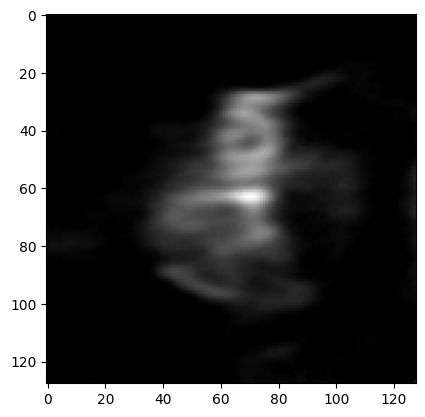

In [5]:
img = cv2.imread('/home/camp/Projects/Yuan/thesis_diffusion-main/output/BraTS/paper_images/brats_coarse_circle_0.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = cv2.resize(img, (128, 128))
img = normalize_image(img, -1, 1)
x_0 = torch.from_numpy(img).float().view(1,1,128,128).to('cuda')

device = 'cuda'

x_0_cache = x_0
difference_map_cache = np.ones_like(x_0.cpu().squeeze().numpy())
iter_num = 0
difference = 255*255


with torch.no_grad():
    while difference > 0.01:
        t = torch.tensor([200], device=x_0_cache.device).repeat(x_0_cache.shape[0])
        noise = diffusion.noise_fn(x_0_cache, None)
        x_t = diffusion.q_sample(x_0_cache, t, noise)
        x_pred = diffusion.p_sample(model, x_t, t)
        # difference_map = create_gaussian_blur_difference_map(x_0, x_pred, kernel_size=gaussian_blur_kernel_size,
        #                                                      threshold=anomaly_threshold)
        difference_map = create_gaussian_blur_difference_map(x_0, x_pred,
                                                             kernel_size=3,
                                                             threshold=0.1)
        # difference_map_s = create_gaussian_blur_difference_map(x_0, x_pred, kernel_size=gaussian_blur_kernel_size,
        #                                                      threshold=anomaly_threshold)
        # x_0_cache=x_pred
        difference_map = difference_map.astype(bool).astype(int)
    
        difference_map_t = torch.from_numpy(difference_map)
        difference_map_t = difference_map_t.view(1,1,128,128).to(device)
        x_0_cache = x_pred*difference_map_t+x_0*(1-difference_map_t)
    
    
        nominator = np.abs(np.sum(difference_map_cache.astype(bool).astype(int))-np.sum(difference_map.astype(bool).astype(int)))
        denominator = np.max([np.sum(difference_map_cache.astype(bool).astype(int)),500])
        difference = nominator/denominator
        difference_map_cache = difference_map
        iter_num += 1
        if iter_num>=5:
            break
    
rec = x_pred.cpu().detach().numpy().squeeze()

rec = normalize_image(rec, 0, 255)
print(rec.shape)
plt.imshow(rec, cmap='gray')
cv2.imwrite('/home/camp/Projects/Yuan/thesis_diffusion-main/output/Ultrasound/paper_images/us_synomaly_multi.png', rec)

anomaly_map = create_gaussian_blur_difference_map(x_0,x_rec,kernel_size=15, threshold=0.2)

anomaly_map = normalize_image(anomaly_map,0,1)
anomaly_map = plt.cm.viridis(anomaly_map)
anomaly_map = anomaly_map[:, :, :3]

anomaly_map = (anomaly_map * 255).astype(np.uint8)
anomaly_map = cv2.cvtColor(anomaly_map, cv2.COLOR_RGB2BGR)

plt.imshow(x_t.cpu().numpy().squeeze())
# cv2.imwrite('/home/camp/Projects/Yuan/thesis_diffusion-main/output/Ultrasound/paper_images/us_synomaly_multi_anomaly_map.png', anomaly_map)

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
using_server = 'None'  # ['IFL', 'TranslaTUM', 'None']
plot_images = False
num_test_images = 1000   # BRATS: 1000 anomalous, 416 healthy; US: 545 anomalous, 812 healthy; Lits: 1000 anomalous, 647 healthy
json_file = "args_us_27"
healthy_or_anomalous_mode = "anomalous"          # ["anomalous", "healthy"]
model_stage = "best_model.pt"   # [checkpoint/diff_epoch=130.pt, params-final.pt, best_model.pt]

In [3]:
noise_steps = [200]
gaussian_kernel_sizes = [5]
anomaly_thresholds = [0.1]

start_time = time.time()

anomaly_detection(json_file, model_stage, noise_steps, gaussian_kernel_sizes,
                  anomaly_thresholds, server=using_server, mode=healthy_or_anomalous_mode, num_test_img=num_test_images,
                  plot_img=plot_images)

time_taken = time.time() - start_time
print(f"Total time taken: {int(time_taken // 3600)}h {int((time_taken // 60) % 60)}min")

Testing on model args_us_27/best_model.pt
Testing on 545 randomly selected images. Mode: anomalous
Testing on inference noise steps: [200] gaussian blur kernel sizes: [5] anomaly thresholds: [0.1]
synomaly Noise steps: 200, kernel size: 5, threshold: 0.1
Average DICE score: 0.5941+-0.1257, average AUPRC score: 0.6558+-0.1005, average IOU score: 0.4337+-0.1255, average Precision: 0.5071+-0.1588, average Recall: 0.7835+-0.1474, average FPR: 0.0908+-0.0583, average Hausdorff: 4.7992+-0.7387, average SSIM: 0.73+-0.0553
Time taken: 08 seconds
synomaly Best combinations:
#1 Combination: (200, 5, 0.1) Dice score: 0.5941+-0.1257, AUPRC score: 0.6558+-0.1005, IoU score: 0.4337+-0.1255, Hausdorff score: 4.7992+-0.7387
Total time taken: 0h 0min


In [10]:
def generate_synomaly_noise(x, synth_anomaly_masks, mode, anomaly_sigma=7, anomaly_threshold=150, anomaly_offset=0.5, anomaly_direction=1):
    
    noise = torch.zeros(x.shape)
    height, width = x.shape[2:4]

    for i in range(x.shape[0]):
        # create Gaussian background noise
        background_noise = np.random.randn(height, width)

        if mode == "inference":  # do not add synthetic anomalies in inference
            noise[i, 0] = torch.from_numpy(background_noise)

        else:
            # create a mask for shapes
            blur = cv2.GaussianBlur(background_noise, (0, 0), sigmaX=anomaly_sigma, sigmaY=anomaly_sigma, borderType=cv2.BORDER_DEFAULT)
            stretch = skimage.exposure.rescale_intensity(blur, in_range='image', out_range=(0, 255))
            shape_mask = cv2.threshold(stretch, anomaly_threshold, 1, cv2.THRESH_BINARY)[1]

            # crop the mask only to relevant area
            if synth_anomaly_masks is not None:
                synth_anomaly_mask = synth_anomaly_masks[i, 0].cpu().numpy()   # -1 regions not add synthetic anomaly, 1 regions add synthetic anomaly
                shape_mask[synth_anomaly_mask == -1] = 0

            # combine background noise and shape noise
            combined = background_noise.copy()

            combined[shape_mask == 1] += anomaly_direction * (torch.rand(1).item() + anomaly_offset)  # add or reduce 0.0-1.0 plus offset

            noise[i, 0] = torch.from_numpy(combined)

    return noise.to(x.device), shape_mask

-4.3773603 6.813073


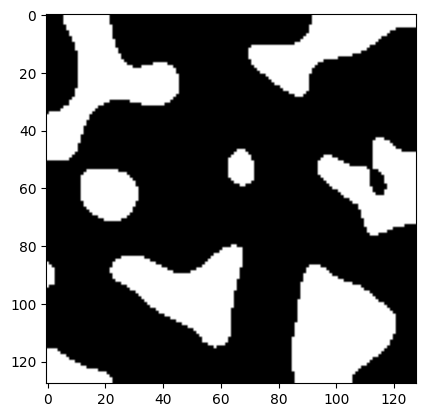

In [22]:
x = torch.randn([1,1,128,128])


mode = 'training'
anomaly_sigma = 7
anomaly_threshold = 150
anomaly_offset = 1
anomaly_direction = 1

center_y, center_x = 128 // 2, 128 // 2

Y, X = np.ogrid[:128, :128]

dist_from_center = (X - center_x) ** 2 + (Y - center_y) ** 2

radius = 128 // 2.2

single_vessel_mask = (dist_from_center <= radius ** 2).astype(int)*2-1

synth_anomaly_masks = torch.from_numpy(single_vessel_mask).view(1,1,128,128)

synth_anomaly_masks = None

noise, shape_mask = generate_synomaly_noise(x, synth_anomaly_masks, mode, anomaly_sigma, anomaly_threshold, anomaly_offset, anomaly_direction)

noise = noise.cpu().detach().numpy().squeeze()
print(noise.min(),noise.max())
noise = normalize_image(noise, 0, 255)
plt.imshow(shape_mask,cmap='gray')
# plt.imshow(single_vessel_mask)
# cv2.imwrite('noise_11_150.png',noise)

In [110]:
np.mean([])

nan

In [23]:
betas = get_beta_schedule('linear', 1000)
betas = np.array(betas, dtype=np.float64)
alphas = 1.0 - betas
sqrt_alphas = np.sqrt(alphas)
sqrt_betas = np.sqrt(betas)
alphas_cumprod = np.cumprod(alphas, axis=0)
sqrt_alphas_cumprod = np.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = np.sqrt(1.0 - alphas_cumprod)

In [97]:
def normalize_image(image, low, high):
    """
    Normalize the input image to the range [low, high].
    
    :param image: Input image as a NumPy array.
    :param low: The lower bound of the target range.
    :param high: The upper bound of the target range.
    
    :return: The normalized image as a NumPy array.
    """
    # Find the minimum and maximum pixel values in the image
    min_val = np.min(image)
    max_val = np.max(image)
    
    # Normalize the image to the range [low, high]
    normalized_image = (image - min_val) / (max_val - min_val) * (high - low) + low
    
    # Convert the image to the appropriate data type (uint8 for an image)
    normalized_image = normalized_image
    
    return normalized_image

-3.8857155 4.67546


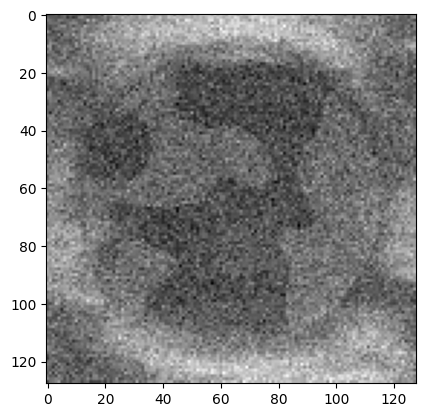

In [432]:
x = torch.randn([1,1,128,128])


mode = 'training'
anomaly_sigma = 7
anomaly_threshold = 150
anomaly_offset = 0.8
anomaly_direction = 1

center_y, center_x = 128 // 2, 128 // 2

Y, X = np.ogrid[:128, :128]

dist_from_center = (X - center_x) ** 2 + (Y - center_y) ** 2

radius = 128 // 2.5

single_vessel_mask = (dist_from_center <= radius ** 2).astype(int)*2-1

synth_anomaly_masks = torch.from_numpy(single_vessel_mask).view(1,1,128,128)

noise = generate_synomaly_noise(x, synth_anomaly_masks, mode, anomaly_sigma, anomaly_threshold, anomaly_offset, anomaly_direction)

noise = noise.cpu().detach().numpy().squeeze()
print(noise.min(),noise.max())




t = 100

x_0 = cv2.imread('/home/camp/Projects/Yuan/thesis_diffusion-main/output/Ultrasound/paper_images/healthy_ultrasound_example_2.png')
x_0 = cv2.cvtColor(x_0, cv2.COLOR_BGR2GRAY)
x_0 = cv2.resize(x_0, (128, 128), interpolation=cv2.INTER_LINEAR)
x_0 = normalize_image(x_0, -1, 1)
# noise = cv2.imread('/home/camp/Projects/Yuan/Documents/figures/noise_functions/us_synomaly_principle_healthy4.png')
# noise_normalized = normalize_image(noise,-1,1)
# noise = np.random.randn(128, 128)
# print(noise.min(),noise.max())


corrupted_img_h = sqrt_alphas_cumprod[t]*x_0+sqrt_one_minus_alphas_cumprod[t]*noise

corrupted_img_h = normalize_0_255(corrupted_img_h)

plt.imshow(corrupted_img_h,cmap='gray')

-3.6053695005515625 4.5476623


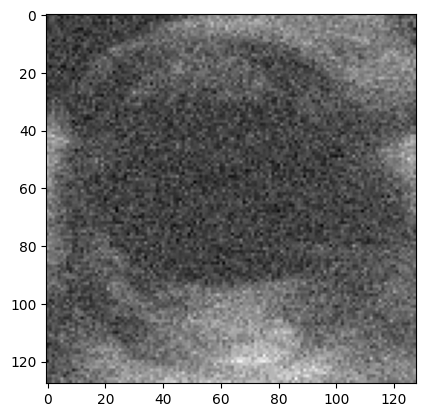

In [298]:
t = 75

x_0 = cv2.imread('/home/camp/Projects/Yuan/thesis_diffusion-main/output/Ultrasound/paper_images/subplot_0.png')
x_0 = cv2.cvtColor(x_0, cv2.COLOR_BGR2GRAY)
x_0 = cv2.resize(x_0, (128, 128), interpolation=cv2.INTER_LINEAR)
x_0 = normalize_image(x_0, -1, 1)
# noise = cv2.imread('/home/camp/Projects/Yuan/Documents/figures/noise_functions/us_synomaly_principle_healthy4.png')
# noise_normalized = normalize_image(noise,-1,1)
noise_g = np.random.randn(128, 128)
print(noise_g.min(),noise.max())


corrupted_img_a = sqrt_alphas_cumprod[t]*x_0+sqrt_one_minus_alphas_cumprod[t]*noise_g

corrupted_img_a = normalize_0_255(corrupted_img_a)

plt.imshow(corrupted_img_a,cmap='gray')

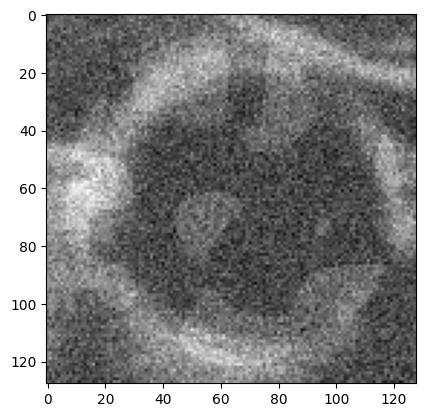

In [155]:
plt.imshow(corrupted_img, cmap='gray')

In [434]:
cv2.imwrite('/home/camp/Projects/Yuan/thesis_diffusion-main/output/Ultrasound/paper_images/corrupted_anomalous_image_2.png',corrupted_img_a)

True

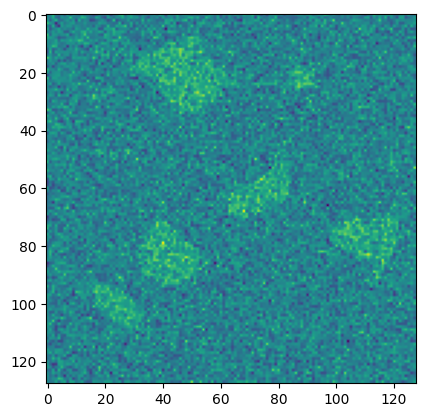

In [162]:
plt.imshow(noise)

In [123]:
cv2.imwrite('/home/camp/Projects/Yuan/Documents/figures/noise_functions/corrupted_image_150_gaussian.png',corrupted_img)

True

In [ ]:
(extract(sqrt_alphas_cumprod, t, x_0.shape) * x_0 +
                extract(sqrt_one_minus_alphas_cumprod, t, x_0.shape) * noise)

In [438]:
def generate_pyramid_noise(x,discount=0.8):
    u = transforms.Resize(x.shape[2], antialias=True)
    noise = torch.randn_like(x)
    w = x.shape[2]
    h = x.shape[3]
    for i in range(10):
        r = random.random() * 2 + 2  # Rather than always going 2x,
        w, h = max(1, int(w / (r ** i))), max(1, int(h / (r ** i)))
        noise += u(torch.randn_like(x)) * discount ** i
        if w == 1 or h == 1:
            break  # Lowest resolution is 1x1
    return noise / noise.std()  # Scaled back to roughly unit variance

-3.9197295 4.0074196


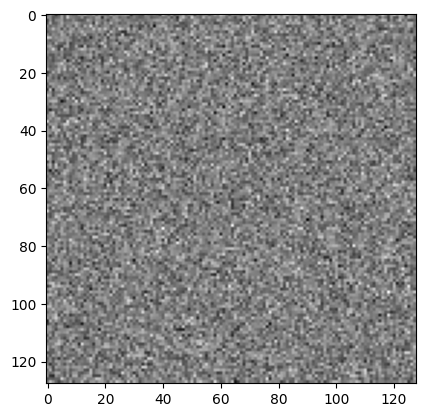

In [444]:
x = torch.randn([1,1,128,128])
noise = generate_pyramid_noise(x)
noise = noise.cpu().detach().numpy().squeeze()
print(noise.min(),noise.max())
plt.imshow(noise,cmap='gray')

In [454]:
def coarse_noise(x,noise_res=16,noise_std=0.2):

    ns = torch.normal(mean=torch.zeros(x.shape[0], x.shape[1], noise_res, noise_res), std=noise_std).to(x.device)

    ns = F.upsample_bilinear(ns, size=[128, 128])

    # Roll to randomly translate the generated noise.
    roll_x = random.choice(range(128))
    roll_y = random.choice(range(128))
    ns = torch.roll(ns, shifts=[roll_x, roll_y], dims=[-2, -1])

    mask = x.sum(dim=1, keepdim=True) > 0.01
    ns *= mask # Only apply the noise in the foreground.

    return ns.clamp(min=0)

0.0 0.46484786


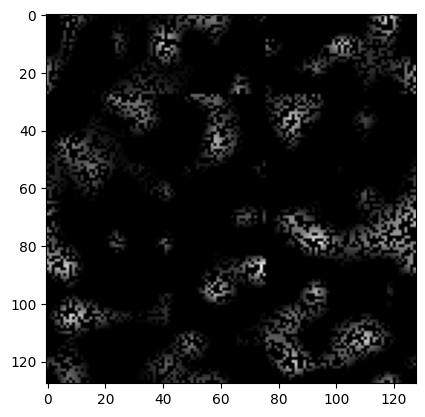

In [455]:
from torch.nn import functional as F
x = torch.randn([1,1,128,128])
noise = coarse_noise(x)
noise = noise.cpu().detach().numpy().squeeze()
print(noise.min(),noise.max())
plt.imshow(noise,cmap='gray')

In [12]:
import pickle
with open(f"/home/camp/Projects/Yuan/thesis_diffusion-main/output/Ultrasound/anomalous_dataset_unet.pkl", "rb") as f:
    anomaly_imgs = pickle.load(f)
with open(f"/home/camp/Projects/Yuan/thesis_diffusion-main/output/Ultrasound/anomalous_masks_unet.pkl", "rb") as f:
    anomaly_masks = pickle.load(f)

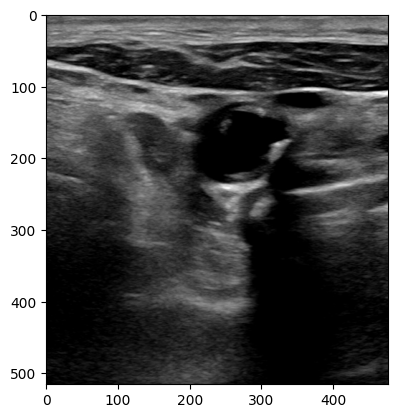

In [11]:
plt.imshow(anomaly_imgs[0],cmap='gray')

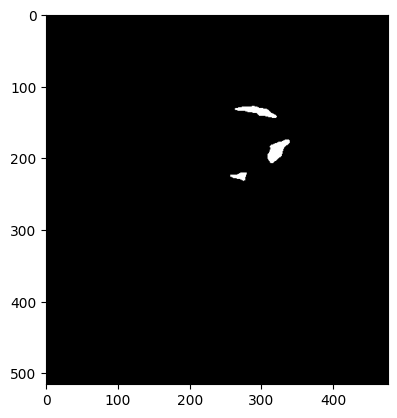

In [13]:
plt.imshow(anomaly_masks[0],cmap='gray')

In [20]:

data = np.load(f"/home/camp/Projects/Yuan/thesis_diffusion-main/output/BraTS/test_anomalous_dataset.npy")
anomaly_masks = np.load(f"/home/camp/Projects/Yuan/thesis_diffusion-main/output/BraTS/test_anomalous_masks.npy")


In [22]:
print(np.min(data[10]),np.max(data[10]))

0.0 2775.0


In [18]:
with open(f"/home/camp/Projects/Yuan/thesis_diffusion-main/output/LiTS/test_anomalous_abdomen_dataset.pkl", "rb") as f:
    data = pickle.load(f)

In [19]:
len(data)

1000

In [3]:
import pickle
img_set = '../output/Ultrasound/test_anomalous_dataset.pkl'

with open(img_set, "rb") as f:
    anomaly_imgs = pickle.load(f)

In [45]:
len(anomaly_imgs)

545

In [51]:
img_path = '/home/camp/Projects/Yuan/thesis_diffusion-main/output/Ultrasound/paper_images/example_4/subplot_0.png'
og_img = cv2.imread(img_path)
og_img = cv2.cvtColor(og_img, cv2.COLOR_BGR2GRAY)
og_img = cv2.resize(og_img, (128,128), interpolation=cv2.INTER_LINEAR)
min_diff = np.inf
best_match = None
best_match_index = None
for i, img in enumerate(anomaly_imgs):
    img = cv2.resize(img, (128,128), interpolation=cv2.INTER_LINEAR)
    diff = np.sum((img-og_img)**2)
    if diff<min_diff:
        best_match = img
        best_match_index = i
        min_diff = diff

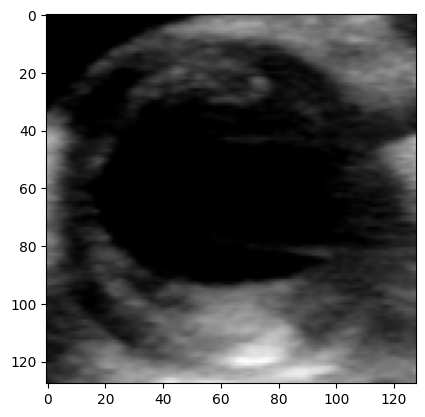

In [52]:
plt.imshow(best_match,cmap = 'gray')

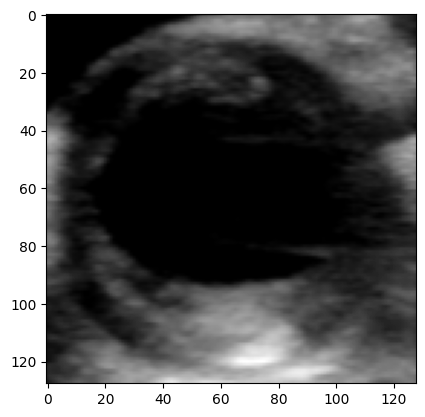

In [53]:
plt.imshow(og_img,cmap = 'gray')

In [54]:
print(best_match_index)

114


In [57]:
img_set = '../output/Ultrasound/anomalous_dataset_unet.pkl'

with open(img_set, "rb") as f:
    anomaly_imgs_unet = pickle.load(f)

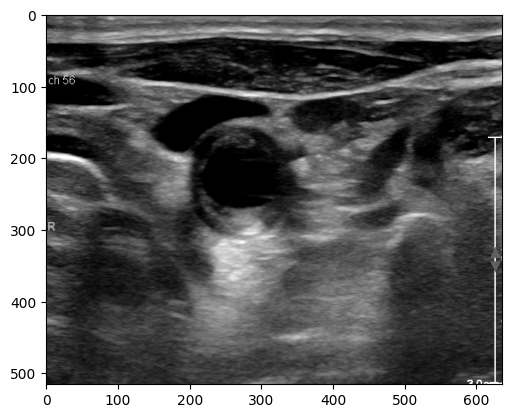

In [58]:
plt.imshow(anomaly_imgs_unet[114],cmap='gray')

In [61]:
cv2.imwrite('/home/camp/Projects/Yuan/thesis_diffusion-main/output/Ultrasound/paper_images/original_us_image_anomalous.png',anomaly_imgs_unet[114])

True

In [46]:
# import pickle
# img_set = '../output/Brats/train_healthy_dataset.pkl'

# img_set = '../output/BraTS/test_anomalous_dataset.npy'
# label_set = '../output/BraTS/test_anomalous_masks.npy'

img_set = '../output/LiTS/test_anomalous_abdomen_dataset.pkl'
label_set = '../output/LiTS/test_anomalous_tumor_masks.pkl'

img_set = '../output/Ultrasound/test_anomalous_dataset.pkl'
label_set = '../output/Ultrasound/test_anomalous_masks.pkl'


# with open(img_set, "rb") as f:
#     healthy_imgs = pickle.load(f)

# anomaly_imgs = np.load(img_set)
# anomaly_masks = np.load(label_set)

with open(img_set, "rb") as f:
    anomaly_imgs = pickle.load(f)

with open(label_set, "rb") as f:
    anomaly_masks = pickle.load(f)

In [89]:
img_path = '/home/camp/Projects/Yuan/thesis_diffusion-main/paper_images/anomalous_ultrasound_example_3.png'
og_img = cv2.imread(img_path)
og_img = cv2.cvtColor(og_img, cv2.COLOR_BGR2GRAY)
og_img = cv2.resize(og_img, (128,128), interpolation=cv2.INTER_LINEAR)
og_img = normalize_image(og_img,0,255)
min_diff = np.inf
best_match = None
best_match_index = None
for i, img in enumerate(anomaly_imgs):
    img = cv2.resize(img, (128,128), interpolation=cv2.INTER_LINEAR)
    img = normalize_image(img,0,255)
    diff = np.sum((img-og_img)**2)
    if diff<min_diff:
        best_match = img
        best_match_index = i
        min_diff = diff

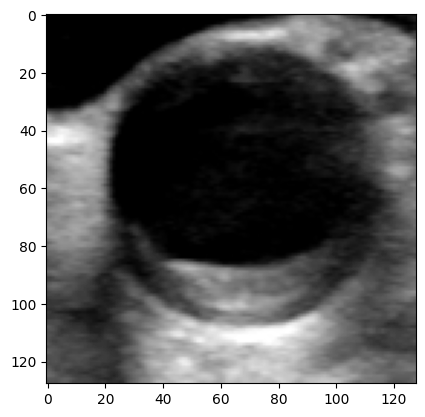

In [90]:
plt.imshow(best_match,cmap = 'gray')

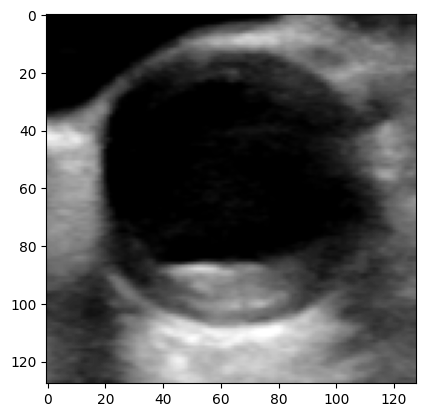

In [91]:
plt.imshow(og_img,cmap = 'gray')

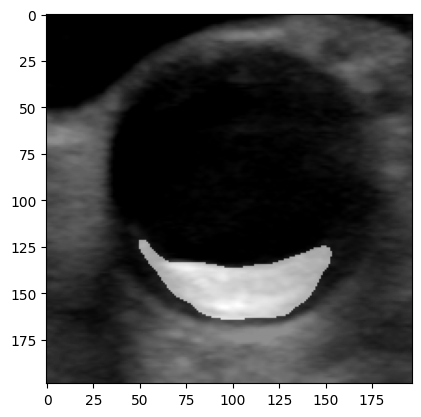

In [92]:
plt.imshow(anomaly_imgs[best_match_index]/255+anomaly_masks[best_match_index],cmap = 'gray')

True

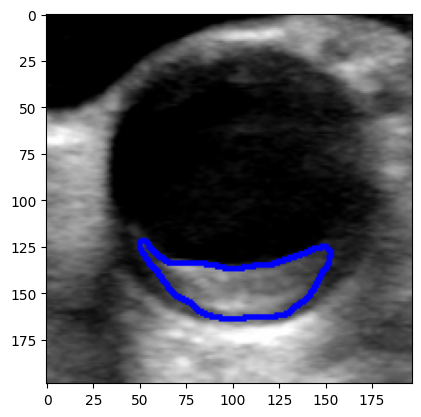

In [94]:
# img_path = '/home/camp/Projects/Yuan/thesis_diffusion-main/paper_images/anomalous_ultrasound_example_1.png'
image = cv2.cvtColor(anomaly_imgs[best_match_index], cv2.COLOR_GRAY2BGR)
mask = anomaly_masks[best_match_index]
# Find contours of the mask (note: mask should be binary, i.e., 0 for background, 255 for foreground)
contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Draw the contours on the original image
# Use red color (BGR format: (0, 0, 255)) and thickness of 2
image_with_boundary = cv2.drawContours(image.copy(), contours, -1, (0, 0, 255), thickness=2)

# Display the image with the red contour drawn
plt.imshow(image_with_boundary)
save_file_name = os.path.splitext(os.path.basename(img_path))[0]+'_plus_label.png'
save_path = os.path.join(os.path.dirname(img_path),save_file_name)
cv2.imwrite(save_path, image_with_boundary)

In [64]:
import os
save_file_name = os.path.splitext(os.path.basename(img_path))[0]+'_label.png'
save_path = os.path.join(os.path.dirname(img_path),save_file_name)
cv2.imwrite(save_path, anomaly_masks[best_match_index]*255)

True

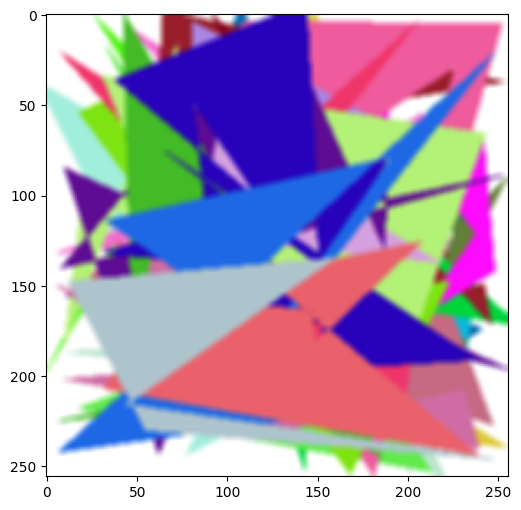

In [1]:
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt


def generate_random_irregular_shape(image, image_size):
    """
    Generate and draw a random irregular shape on the canvas using OpenCV.
    """
    # Number of points for the shape
    num_points = random.randint(5, 12)
    
    # Generate random points
    points = np.array([
        [
            random.randint(0, image_size[0]), 
            random.randint(0, image_size[1])
        ]
        for _ in range(num_points)
    ], dtype=np.int32)
    
    # Add noise to points for more irregularity
    noise = np.random.randint(-10, 10, points.shape)
    noisy_points = points + noise
    
    # Smooth the shape using Bézier-like approximation
    curve_points = cv2.approxPolyDP(noisy_points, epsilon=15, closed=True)
    
    # Random color for the shape
    color = tuple(random.randint(0, 255) for _ in range(3))
    
    # Draw the shape on the image
    cv2.fillPoly(image, [curve_points], color)


# Create a blank canvas
image_size = (256, 256)
image = np.ones((image_size[1], image_size[0], 3), dtype=np.uint8) * 255  # White background

# Number of random shapes
num_shapes = random.randint(10, 30)

# Draw shapes
for _ in range(num_shapes):
    generate_random_irregular_shape(image, image_size)

# Apply Gaussian blur for smoother visuals
blurred_image = cv2.GaussianBlur(image, (5, 5), 2)

# Convert BGR (OpenCV format) to RGB (Matplotlib format)
blurred_image_rgb = cv2.cvtColor(blurred_image, cv2.COLOR_BGR2RGB)

# Display the image using Matplotlib
plt.figure(figsize=(6, 6))
plt.imshow(blurred_image_rgb)